<a href="https://colab.research.google.com/github/Eduardo6446/BIMMO_IA/blob/main/BIMMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalamos e importamos las librerías necesarias.
# Pandas para manejar datos, Sklearn para procesarlos y TensorFlow para la IA.

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib # Para guardar los codificadores (LabelEncoders)

In [2]:
# Cargamos el archivo JSONL que generaste con el script anterior.
# Asegúrate de haber subido 'datos_entrenamiento_fase2.jsonl' a Colab.

archivo_datos = 'datos_entrenamientoV2.jsonl'

try:
    # lines=True es vital para leer JSONL
    df = pd.read_json(archivo_datos, lines=True)
    print("✅ Datos cargados exitosamente.")
    print(f"Total de registros: {len(df)}")
    print("\nVista previa de los datos:")
    print(df[['modelo_id', 'componente_id', 'km_realizado_usuario', 'condicion_reportada']].head())
except ValueError as e:
    print(f"❌ Error al cargar datos: {e}")
    print("Asegúrate de que el archivo existe y es un JSONL válido.")

✅ Datos cargados exitosamente.
Total de registros: 19300

Vista previa de los datos:
            modelo_id          componente_id  km_realizado_usuario  \
0        Hero_Eco_150  zapatas_freno_trasero                  2439   
1      Keeway_RKS_125           aceite_motor                   809   
2   Hero_Hunk_160R_4V                  bujia                 54541   
3      Keeway_RKS_125           kit_arrastre                  1251   
4  Bajaj_Pulsar_NS160           aceite_motor                  2022   

  condicion_reportada  
0     desgaste_normal  
1          como_nuevo  
2       fallo_critico  
3          como_nuevo  
4      muy_desgastado  


In [3]:
# La IA no entiende texto (ej: "Bajaj_Pulsar_NS200"), solo números.
# Aquí convertimos todas las palabras a números usando LabelEncoders.

# 1. Crear codificadores para columnas de texto
le_modelo = LabelEncoder()
le_componente = LabelEncoder()
le_condicion = LabelEncoder() # Este es nuestro objetivo (Target)

# 2. Ajustar y transformar los datos
df['modelo_encoded'] = le_modelo.fit_transform(df['modelo_id'])
df['componente_encoded'] = le_componente.fit_transform(df['componente_id'])
df['condicion_encoded'] = le_condicion.fit_transform(df['condicion_reportada'])

# 3. Normalizar el kilometraje (Escalarlo para que esté entre -1 y 1 aprox)
# Esto ayuda a que la red neuronal aprenda más rápido.
scaler_km = StandardScaler()
# reshape(-1, 1) es necesario porque scaler espera una matriz 2D
df['km_scaled'] = scaler_km.fit_transform(df['km_realizado_usuario'].values.reshape(-1, 1))

print("✅ Datos procesados.")
print("Ejemplo de mapeo de condiciones (Target):")
for i, clase in enumerate(le_condicion.classes_):
    print(f"  {i} -> {clase}")

# Guardamos los encoders para usarlos luego en la app
joblib.dump(le_modelo, 'encoder_modelo.pkl')
joblib.dump(le_componente, 'encoder_componente.pkl')
joblib.dump(le_condicion, 'encoder_condicion.pkl')
joblib.dump(scaler_km, 'scaler_km.pkl')
print("\n💾 Encoders guardados (los necesitarás para hacer predicciones reales).")

✅ Datos procesados.
Ejemplo de mapeo de condiciones (Target):
  0 -> como_nuevo
  1 -> desgaste_normal
  2 -> fallo_critico
  3 -> muy_desgastado

💾 Encoders guardados (los necesitarás para hacer predicciones reales).


In [4]:
# Separamos las "Entradas" (X) de la "Salida deseada" (y).
# También dividimos en datos de Entrenamiento (80%) y Prueba (20%).

# Entradas: Modelo (numérico), Componente (numérico), KM (escalado)
X = df[['modelo_encoded', 'componente_encoded', 'km_scaled']]

# Salida: Condición (numérico)
y = df['condicion_encoded']

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (15440, 3)
Datos de prueba: (3860, 3)


In [5]:
# Diseñamos la arquitectura de la red neuronal con TensorFlow/Keras.

num_clases = len(le_condicion.classes_)

model = tf.keras.models.Sequential([
    # Capa de entrada (3 características: modelo, componente, km)
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),

    # Capas ocultas (donde ocurre la "magia" del aprendizaje)
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2), # Apaga neuronas al azar para evitar memorización (overfitting)

    # Capa de salida
    # Softmax se usa para clasificación múltiple (nos da % de probabilidad para cada estado)
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

# Compilamos el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # 'Sparse' porque 'y' son enteros (0, 1, 2...), no one-hot vectors
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,468 (9.64 KB)

 Trainable params: 2,468 (9.64 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# ¡Aquí es donde la IA aprende!
# Epochs = Cuántas veces revisará todos los datos.

history = model.fit(
    X_train, y_train,
    epochs=20,           # Puedes aumentar esto si ves que sigue mejorando
    batch_size=32,       # Procesa 32 registros a la vez
    validation_data=(X_test, y_test),
    verbose=1
)

print("✅ Entrenamiento finalizado.")

Epoch 1/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2810 - loss: 1.4038 - val_accuracy: 0.3078 - val_loss: 1.3522
Epoch 2/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3024 - loss: 1.3614 - val_accuracy: 0.3189 - val_loss: 1.3483
Epoch 3/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3120 - loss: 1.3532 - val_accuracy: 0.3163 - val_loss: 1.3454
Epoch 4/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3007 - loss: 1.3549 - val_accuracy: 0.3187 - val_loss: 1.3381
Epoch 5/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3119 - loss: 1.3509 - val_accuracy: 0.3262 - val_loss: 1.3369
Epoch 6/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3187 - loss: 1.3439 - val_accuracy: 0.3194 - val_loss: 1.3356
Epoch 7/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3157 - loss: 1.3437 - val_accuracy: 0.3246 - val_loss: 1.3356
Epoch 8/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3083 - loss: 1.3432 - val_accuracy: 0.

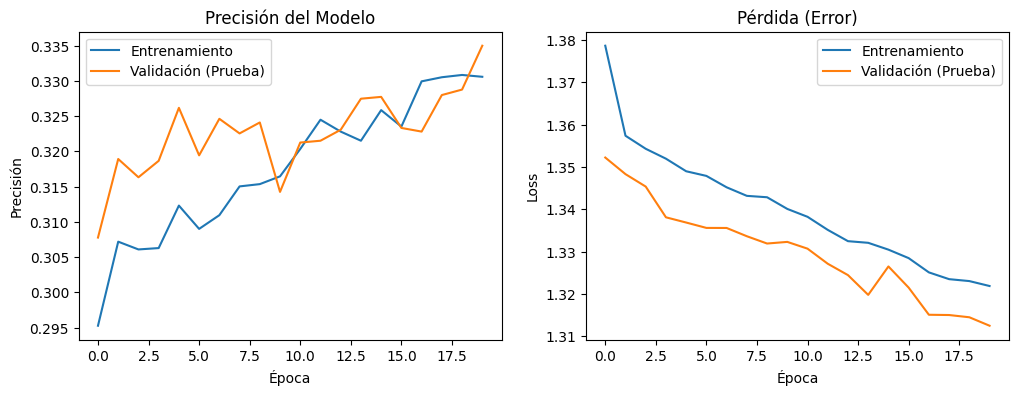

In [7]:
# Visualicemos qué tan bien aprendió.

import matplotlib.pyplot as plt

# Gráfica de Precisión (Accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación (Prueba)')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación (Prueba)')
plt.title('Pérdida (Error)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Probemos el modelo con un caso hipotético manual para ver si tiene sentido.

def predecir_estado(modelo_nombre, componente_nombre, km_usuario):
    try:
        # 1. Convertir entradas al formato que entiende la IA
        # Verificar si el modelo_nombre existe en los encoders
        if modelo_nombre not in le_modelo.classes_:
            raise ValueError(f"El modelo '{modelo_nombre}' no fue encontrado en los datos de entrenamiento.")
        mod_enc = le_modelo.transform([modelo_nombre])[0]

        # Verificar si el componente_nombre existe en los encoders
        if componente_nombre not in le_componente.classes_:
            raise ValueError(f"El componente '{componente_nombre}' no fue encontrado en los datos de entrenamiento.")
        comp_enc = le_componente.transform([componente_nombre])[0]

        km_scl = scaler_km.transform([[km_usuario]])[0][0]

        # 2. Predecir
        prediccion = model.predict([[mod_enc, comp_enc, km_scl]], verbose=0)

        # 3. Interpretar resultado
        clase_ganadora = np.argmax(prediccion)
        estado_texto = le_condicion.inverse_transform([clase_ganadora])[0]
        confianza = np.max(prediccion) * 100

        print(f"\n--- Predicción para {modelo_nombre} ({componente_nombre}) a los {km_usuario} km ---")
        print(f"Estado Predicho: {estado_texto.upper()}")
        print(f"Confianza: {confianza:.2f}%")
        print("Probabilidades por estado:")
        for i, prob in enumerate(prediccion[0]):
            estado = le_condicion.inverse_transform([i])[0]
            print(f"  - {estado}: {prob*100:.1f}%")

    except ValueError as ve:
        # Captura errores específicos de valores (ej. etiquetas no encontradas)
        print(f"❌ Error de entrada: {ve}")
    except Exception as e:
        # Captura cualquier otro error inesperado
        print(f"❌ Error inesperado durante la predicción: {e}")

# ¡CÁMBIAME! Prueba con valores aquí
# Ejemplo: Bujías de una Pulsar NS200 a los 12,000 km (Manual dice cambio a 10,000)
# Debería predecir desgaste alto o muy desgastado.
predecir_estado("Hero_Hunk_160R", "aceite_motor", 1603)

# Ejemplo: Aceite a los 100 km (Recién cambiado)
predecir_estado("Bajaj_Pulsar_NS200", "aceite_motor", 100)


❌ Error inesperado durante la predicción: tuple index out of range
❌ Error inesperado durante la predicción: tuple index out of range


In [9]:
# Exportamos el modelo en formato .h5 (estándar Keras) o SavedModel
# Este archivo es el que luego cargaríamos en el servidor Flask para la Fase 3 real.

model.save("modelo_mantenimiento_v1.h5")
print("✅ Modelo guardado como 'modelo_mantenimiento_v1.h5'")

# Si quieres descargarlo a tu PC desde Colab:
from google.colab import files
files.download("modelo_mantenimiento_v1.h5")
# También descarga los encoders, son indispensables
files.download("encoder_modelo.pkl")
files.download("encoder_componente.pkl")
files.download("encoder_condicion.pkl")
files.download("scaler_km.pkl")

✅ Modelo guardado como 'modelo_mantenimiento_v1.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>